#  Статистика

**Условие**

Имеются 3 файла. В каждом из них содержатся данные, которые необходимо исследовать.

С помощью методов выравнивания статистических рядов подобрать теоретическое распределение. Проверить гипотезы о соответствии закона распределения имеющихся данных теоретическому. (Проверить стандартные распределения, которые использовались раньше: геометрическое, биномиальное, Пуассона, равномерное, нормальное, экспоненциальное).

Выполнить статистическое исследование(построение графиков(ГИСТОГРАММА 100% - без нее сразу 0), точечных, интервальных оценок, p-value).  
Постарайтесь подойти творчески и сделать лабораторную красивой.

В качестве теоретического можно использовать генератор случайных величин из стандартной библиотеки того языка программирования, на котором будет выполняться работа, если это необходимо.


**Требования к работе:**

Реализовать все используемые методы (если будет использовано что-то из библиотек, то придется во время сдачи писать самому ручками, а время-то ограничено..).

чистый код (по аналогии с предыдущим пунктом - в случае плохого кода придется переписывать во время сдачи)

**Пожелания к работе:**

Использовать Python и Jupyter Notebook (https://jupyter.org/)

Описание того, что вы делали

In [2]:
#основные библиотеки, которые понадобятся
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstwo
import math

###  General purpose Functions ###

In [8]:
# dataset_1 = pd.read_excel('set_1.csv.xls') - greate files  (pandas can't read)

def read_data(filename):
    with open(filename) as f:
        string = f.read()
        numbers = np.fromiter(map(float, string.split(',')), dtype='float64')
    return numbers

def create_binedges(center, bandwidth, x_left, x_right):
    """
    Функция для удобного создания бинов заданной ширины и с заданным положением центра одного из бинов
    :param center: Значение центра одного из бинов
    :param bandwidth: Ширина бина
    :param x_left: Значение левой границы самого левого бина не больше x_left
    :param x_right: Значение правой границы самого правого бина не меньше x_right
    """
    bins = [center - bandwidth / 2]
    while x_left < bins[-1]:
        bins.append(bins[-1] - bandwidth)
    bins = list(reversed(bins))
    while x_right > bins[-1]:
        bins.append(bins[-1] + bandwidth)
    return bins

def se(x, n):
    return np.sqrt(np.abs(x * (np.ones(len(x)) - x)) / n)

def z_alpha_2(a):
    return stats.norm.ppf(1 - a / 2)


def histogram_pdf_estimated_risk(bincounts, bandwidth=None, n_bins=None):
    h = bandwidth
    n = np.sum(bincounts)
    ps = bincounts / n
    return 2 / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2)


def gaussian_kernel_pdf_estimated_risk(X, h):
    n = len(X)
    points = (X[None, :] - X[:, None]) / h
    
    result = np.sum(stats.norm(0, np.sqrt(2)).pdf(points) - 2 * stats.norm.pdf(points))
    result /= h * n * n
    result += (2 * stats.norm.pdf(0)) / (n * h)
    return result

def kolmagorov_test(data, theoretical_function, function_name, *args):
    empirical_function = ECDF(data)
    
    k = -1
    emperical = []
    theoretical = []
    for x in np.linspace(0, max(data), len(data)):
        estimated_val = empirical_function(x)
        theoretical_val = theoretical_function(x, *args)
        
        emperical.append(estimated_val)
        theoretical.append(theoretical_val)
        k = max(k, abs(estimated_val - theoretical_val))
        
    if k < 0:
        raise Exception(f"k less than zero {k}")
        
    plt.plot(np.linspace(0, max(data), len(data)), emperical, label="empirical distribution")
    plt.plot(np.linspace(0, max(data), len(data)), theoretical, label=function_name)
    plt.title(function_name)
    plt.legend()
    plt.show()
    
    kol_lambda = k * np.sqrt(len(data))
    p_value = stats.kstwo.sf(k, len(data))
    print(f"Kolmagorov statistic: {kol_lambda}")
    print(f"p_value: {p_value}")
       

def bootstrap(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_sample = np.random.choice(data, size=len(data))
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

    
def plot_histograms(data):
    # find optimum for hist
    
    bandwidth_range = np.linspace(0.01, 10, 10000)
    risk_values = []

    for bandwidth in bandwidth_range:
        binedges = create_binedges(0., bandwidth, data.min(), data.max())
        bincounts, _ = np.histogram(data, bins=binedges)
        risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
    
    risk_values = np.array(risk_values)

    plt.figure(figsize=(10, 8))
    plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2)

    plt.xlabel(r'$h$'); plt.ylabel(r'$\hat{J}(h)$')
    plt.legend()
    plt.grid(which='both', linestyle='--', alpha=0.5)
    plt.show()
    
    # show opitmal values
    
    index_min = np.argmin(risk_values)
    opt_bandwidth = bandwidth_range[index_min]
    min_risk = risk_values[index_min]

    print('h = {}, J = {}'.format(opt_bandwidth, min_risk))
    
    # plot optimal hist
    
    bandwidth = opt_bandwidth
    binedges = create_binedges(0., bandwidth, data.min(), data.max())

    plt.figure(figsize=(10, 8))
    plt.hist(data, bins=binedges, color='b', density=True, edgecolor='k', 
             label='estimated pdf', alpha=0.5, zorder=2)

    plt.xlabel(r'$x$')
    plt.legend()
    plt.grid(which='both', linestyle='--', alpha=0.5)
    plt.title("Optimal bandwidth histogram")
    plt.show()
    
    #plot 95% confidence interval
    
    alpha = 0.05
    y_l = binedges - z_alpha_2(alpha) * se(binedges, len(data))
    y_r = binedges + z_alpha_2(alpha) * se(binedges, len(data))

    plt.figure(figsize=(10, 7))
    plt.hist(data, binedges, label="estimated pdf", alpha = 0.5)
    plt.hist(data, y_l, label="low bound", alpha = 0.5)
    plt.hist(data, y_r, label="upper bound", alpha = 0.5)

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Probability")
    plt.title("Asymptotic normal 95% confidence interval for Histogram with optimal bandwidth")
    plt.show()
    
    
    #find optimum for kernel 
    
    if len(data) > 1000:
        np.random.shuffle(data)
        data_slice = data[:1000] # dataset is too big for my memory
    else:
        data_slice = data

    bandwidth_range = np.linspace(0.01, 3, 500)
    risk_values = []

    for bandwidth in bandwidth_range:
        risk_values.append(gaussian_kernel_pdf_estimated_risk(data_slice, bandwidth))
    
    risk_values = np.array(risk_values)

    plt.figure(figsize=(10, 8))
    plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);

    plt.xlabel(r'$h$'); plt.ylabel(r'$\hat{J}(h)$')
    plt.legend()
    plt.grid(which='both', linestyle='--', alpha=0.5)
    plt.show()
    
    #show optimal values
    
    index_min = np.argmin(risk_values)
    opt_bandwidth = bandwidth_range[index_min]
    min_risk = risk_values[index_min]

    print('h = {}, J = {}'.format(opt_bandwidth, min_risk))
    
    #plot optimal kernel
    
    bandwidth = opt_bandwidth

    plt.figure(figsize=(10, 8))
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data[:,None])
    x_values = np.linspace(np.min(data), np.max(data), 10000)
    y_values = np.exp(kde.score_samples(x_values[:, None]))

    plt.plot(x_values, y_values, label="estimated pdf", color="blue")
    plt.fill_between(x_values, y_values, fc='lightblue')

    plt.xlabel(r'$x$')
    plt.legend()
    plt.grid(which='both', linestyle='--', alpha=0.5)
    plt.title("Optimal bandwidth gaussian kernel")
    plt.show()
    
    #plot 95% confdence interval for kernel estimation
    
    low_bound = np.maximum(y_values - z_alpha_2(alpha) * se(y_values, len(data)), np.zeros(len(y_values)))
    upper_bound = y_values + z_alpha_2(alpha) * se(y_values, len(data))


    plt.figure(figsize=(10, 7))
    plt.plot(x_values, y_values, label="estimated pdf")
    plt.plot(x_values, low_bound, label="low bound")
    plt.plot(x_values, upper_bound, label="upper bound")
    plt.fill_between(x_values, y_values, fc='lightblue')
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Probability")
    plt.title("Asymptotic normal 95% confidence interval for Gaussian Kernel Density.")
    plt.show()
    

### Concrete Functions ###

In [4]:
def test_geom(data, mean, var):
    print("Geometric distribution")
    
    p_estimated = 1 / mean
    var = var * (p_estimated ** 4) / len(data)
    se = np.sqrt(var)
    print(f"Estiamted p: {p_estimated}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound = p_estimated - z_05_2 * se
    high_bound = p_estimated + z_05_2 * se

    print(f"95% Confidence interval: {low_bound}, {high_bound}")
    
    kolmagorov_test(data, stats.geom.cdf, "Geometric distribution", p_estimated)
    
def test_binominal(data, mean, var):
    print("Binomial distribution")
    
    p_estimated = mean / len(data)
    var = var / (len(data) ** 3)
    se = np.sqrt(var)
    print(f"Estiamted p: {p_estimated}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound = p_estimated - z_05_2 * se
    high_bound = p_estimated + z_05_2 * se

    print(f"95% Confidence interval: {low_bound}, {high_bound}")
    
    kolmagorov_test(data, stats.binom.cdf, "Binomial distribution", len(data), p_estimated)
    
def test_poisson(data, mean, var):
    print("Poisson distribution")
    
    lambda_estimated = 1 / mean
    var = var / len(data)
    se = np.sqrt(var)
    print(f"Estiamted lambda: {lambda_estimated}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound = lambda_estimated - z_05_2 * se
    high_bound = lambda_estimated + z_05_2 * se

    print(f"95% Confidence interval: {low_bound}, {high_bound}")
    
    kolmagorov_test(data, stats.poisson.cdf, "Poisson distribution", lambda_estimated)
    
def test_uniform(data, mean, var):
    print("Uniform distribution")
    
    a_estimated = mean - np.sqrt(3) * np.sqrt(var)
    b_estimated = mean + np.sqrt(3) * np.sqrt(var)
    
    a_replicated = bootstrap(data, lambda x: np.mean(x) - np.sqrt(3) * np.std(x), 15000)
    b_replicated = bootstrap(data, lambda x: np.mean(x) + np.sqrt(3) * np.std(x), 15000)
    
    a_se = np.std(a_replicated)
    b_se = np.std(b_replicated)

    print(f"Estiamted a: {a_estimated}")
    print(f"Estimated b: {b_estimated}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound_a = a_estimated - z_05_2 * a_se
    high_bound_a = a_estimated + z_05_2 * a_se
    low_bound_b = b_estimated - z_05_2 * b_se
    high_bound_b = b_estimated + z_05_2 * b_se

    print(f"95% Confidence interval for a: {low_bound_a}, {high_bound_a}")
    print(f"95% Confidence interval for b: {low_bound_b}, {high_bound_b}")    
    
    kolmagorov_test(data, stats.uniform.cdf, "Uniform distribution", a_estimated, b_estimated - a_estimated)
    
    
def test_norm(data, mean, var):
    print("Norm distribution")
    
    mean_replicated = bootstrap(data, np.mean, 15000)
    var_replicated = bootstrap(data, np.var, 15000)
    
    mean_se = np.std(mean_replicated)
    var_se = np.std(var_replicated)
    
    
    print(f"Estimated mean: {mean}")
    print(f"Estimated var: {var}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound_mean = mean - z_05_2 * mean_se
    high_bound_mean = mean + z_05_2 * mean_se
    
    low_bound_var = var - z_05_2 * var_se
    high_bound_var = var + z_05_2 * var_se

    print(f"95% Confidence interval for mean: {low_bound_mean}, {high_bound_mean}")
    print(f"95% Confidence interval for var: {low_bound_var}, {high_bound_var}")
    
    kolmagorov_test(data, stats.norm.cdf, "Normal distribution", mean, np.sqrt(var))
    
def test_exp(data, mean, var):
    print("Exponential")
    
    lambda_estimated = 1 / mean
    var = var * (lambda_estimated ** 4) / len(data)
    se = np.sqrt(var)
    print(f"Estiamted lambda: {lambda_estimated}")
    z_05_2 = stats.norm.ppf(1 - 0.05 / 2)

    low_bound = lambda_estimated - z_05_2 * se
    high_bound = lambda_estimated + z_05_2 * se

    print(f"95% Confidence interval: {low_bound}, {high_bound}")
    
    kolmagorov_test(data, exponential_distribution, "Exponential distribution", lambda_estimated)

### Main Function ###

In [5]:
def process_dataset(data, descrete=True):
    mean = np.mean(data)
    var = np.var(data)
    
    print(f"mean: {mean}")
    print(f"variance: {var}")
    print()
    
    plot_histograms(data)
    
    if descrete:
        test_geom(data, mean, var)
        print()
        test_binominal(data, mean, var)
        print()
        test_poisson(data, mean, var)
        print()
        
    test_uniform(data, mean, var)
    print()
    test_norm(data, mean, var)
    print()
    test_exp(data, mean, var)
    

### Основная часть###

In [6]:
dataset_1 = read_data('set_1.csv.xls')
dataset_2 = read_data('set_2.csv.xls')
dataset_3 = read_data('set_3.csv.xls')
dataset_1

array([3., 1., 1., ..., 1., 1., 3.])

mean: 3.684
variance: 12.472144



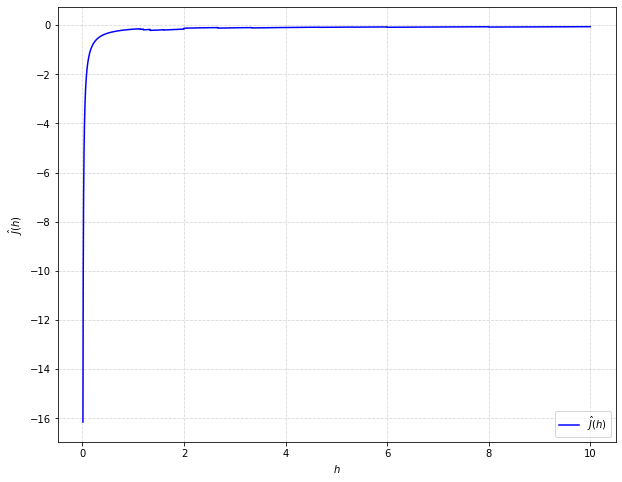

h = 0.01, J = -16.15066886886887


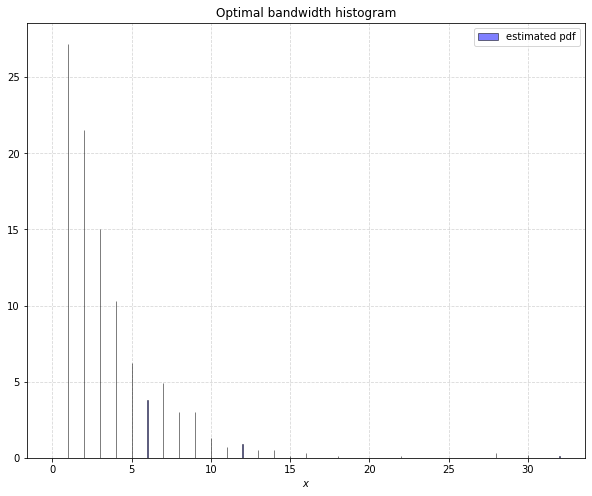

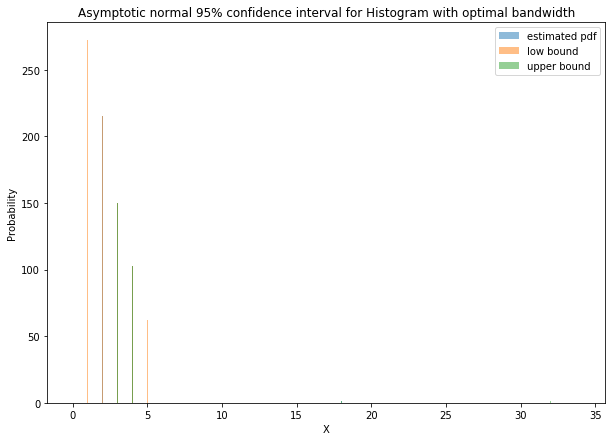

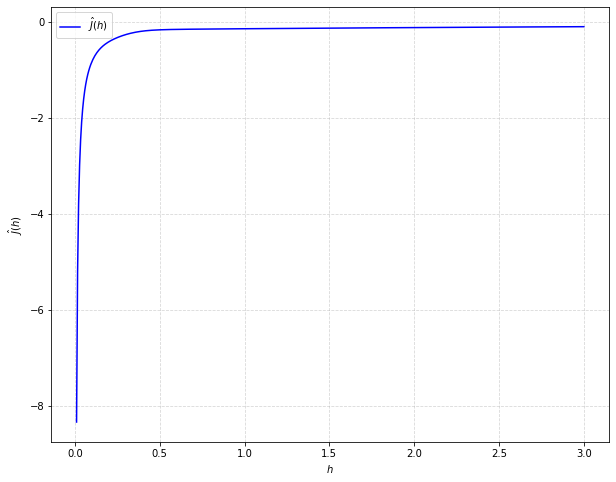

h = 0.01, J = -8.336972152888526


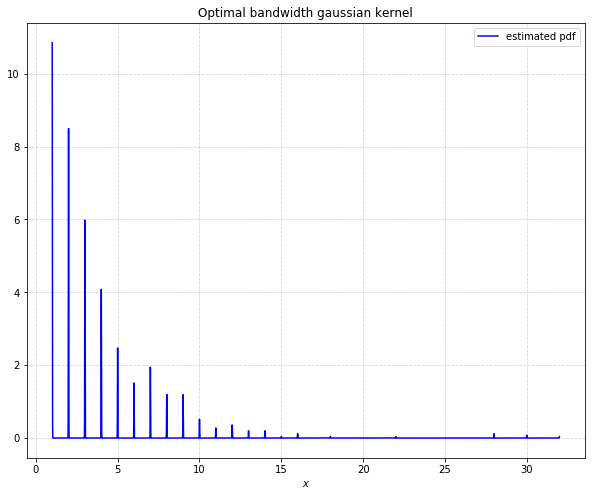

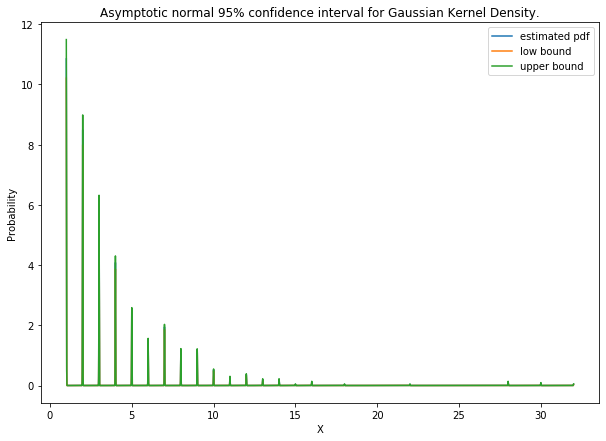

Geometric distribution
Estiamted p: 0.2714440825190011
95% Confidence interval: 0.25531612368678624, 0.28757204135121595


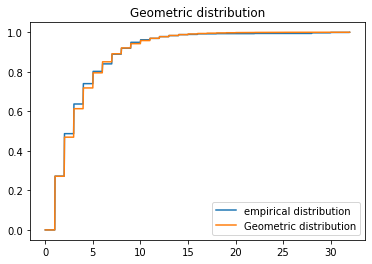

Kolmagorov statistic: 0.7498680313202558
p_value: 0.6186439070886938

Binomial distribution
Estiamted p: 0.003684
95% Confidence interval: 0.0034651136651552518, 0.0039028863348447487


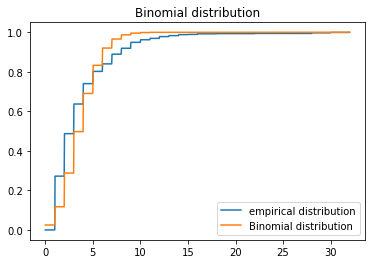

Kolmagorov statistic: 6.304915233796581
p_value: 2.574320223324701e-35

Poisson distribution
Estiamted lambda: 0.2714440825190011
95% Confidence interval: 0.0525577476742527, 0.4903304173637495


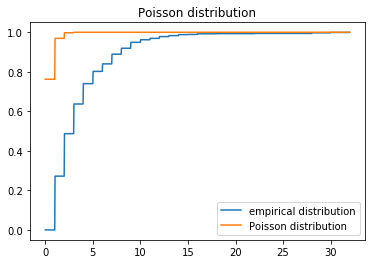

Kolmagorov statistic: 24.105343959458576
p_value: 0.0

Uniform distribution
Estiamted a: -2.43289725269274
Estimated b: 9.80089725269274
95% Confidence interval for a: -3.1167687683075496, -1.749025737077931
95% Confidence interval for b: 8.808067446093636, 10.793727059291845


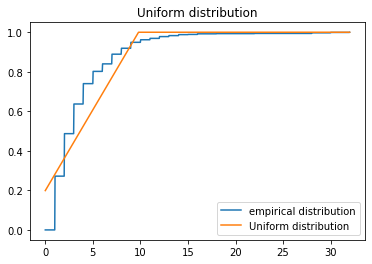

Kolmagorov statistic: 8.855483215245808
p_value: 7.583457077220629e-70

Norm distribution
Estimated mean: 3.684
Estimated var: 12.472144
95% Confidence interval for mean: 3.4642720462968253, 3.903727953703175
95% Confidence interval for var: 9.072191315584782, 15.872096684415219


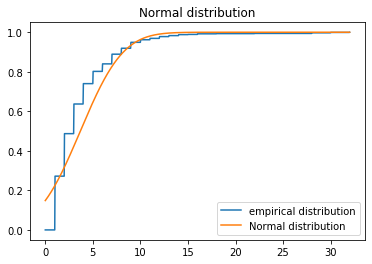

Kolmagorov statistic: 7.0530051117785
p_value: 3.521352320410694e-44

Exponential
Estiamted lambda: 0.2714440825190011
95% Confidence interval: 0.25531612368678624, 0.28757204135121595


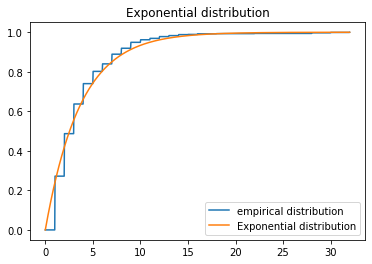

Kolmagorov statistic: 7.471540392844646
p_value: 1.362608549170864e-49


In [11]:
np.random.shuffle(dataset_1)
process_dataset(dataset_1[:1000]) #heavy computations

mean: 17.495191989000002
variance: 10639.883141055687



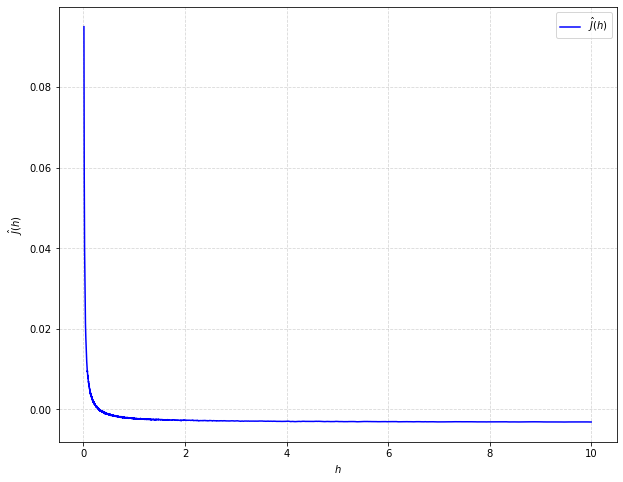

h = 9.470477047704769, J = -0.0031355684808429146


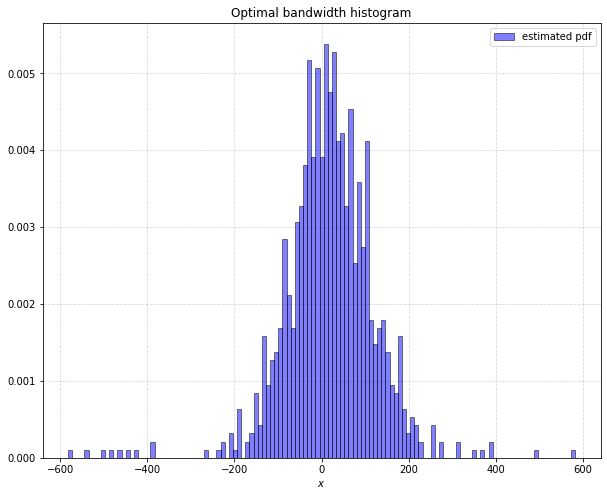

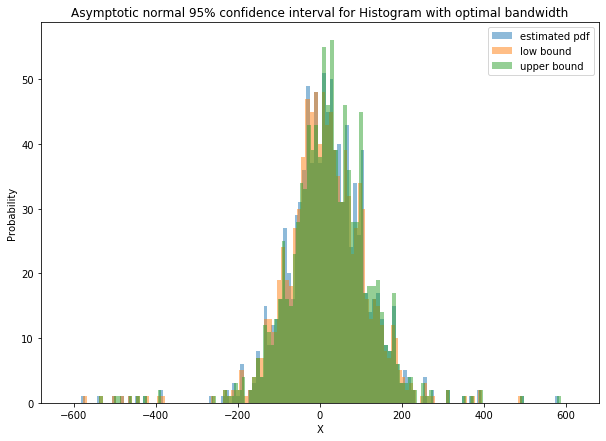

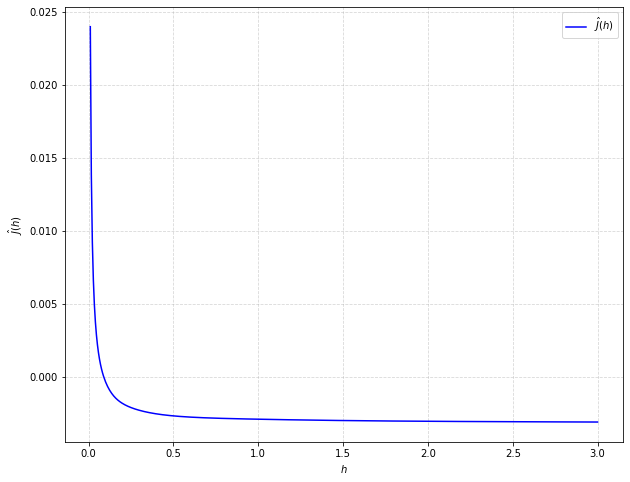

h = 3.0, J = -0.0031130812252067245


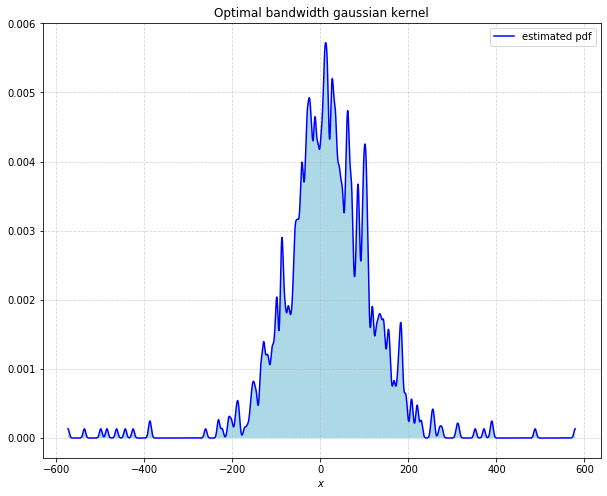

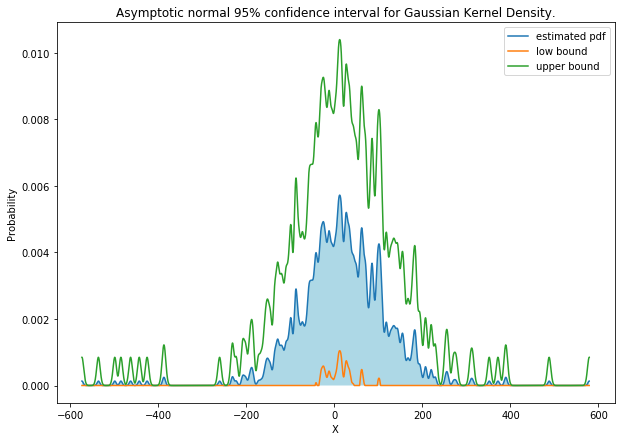

Geometric distribution
Estiamted p: 0.05715856108516809
95% Confidence interval: 0.03627141546064178, 0.0780457067096944


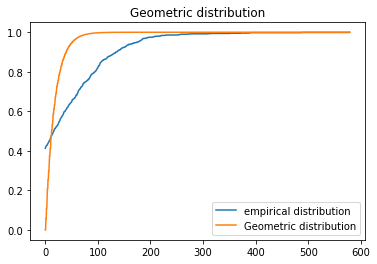

Kolmagorov statistic: 13.155075066300459
p_value: 3.2140927499325707e-157

Binomial distribution
Estiamted p: 0.017495191989000004
95% Confidence interval: 0.011102018055548554, 0.023888365922451454


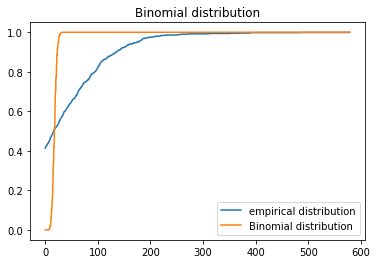

Kolmagorov statistic: 14.092158962516008
p_value: 1.4540703933765493e-181

Poisson distribution
Estiamted lambda: 0.05715856108516809
95% Confidence interval: -6.3360153723662815, 6.450332494536617


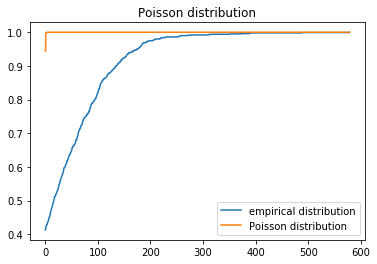

Kolmagorov statistic: 18.2282343565431
p_value: 1.9629539e-315

Uniform distribution
Estiamted a: -161.16551836212074
Estimated b: 196.15590234012075
95% Confidence interval for a: -178.5243602007382, -143.80667652350328
95% Confidence interval for b: 180.8627561476352, 211.4490485326063


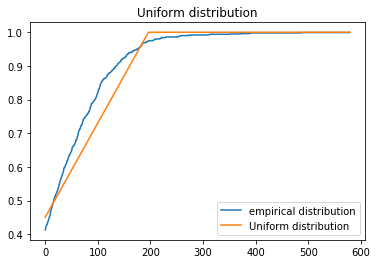

Kolmagorov statistic: 3.2185304180689984
p_value: 1.7988406093365496e-09

Norm distribution
Estimated mean: 17.495191989000002
Estimated var: 10639.883141055687
95% Confidence interval for mean: 11.047316926913311, 23.943067051086693
95% Confidence interval for var: 8862.441914270828, 12417.324367840545


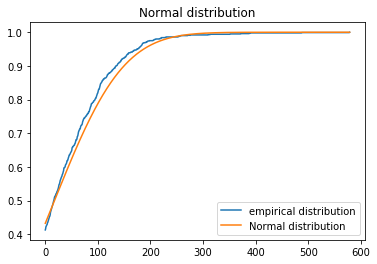

Kolmagorov statistic: 1.4278198888410065
p_value: 0.032868018718933856

Exponential
Estiamted lambda: 0.05715856108516809
95% Confidence interval: 0.03627141546064178, 0.0780457067096944


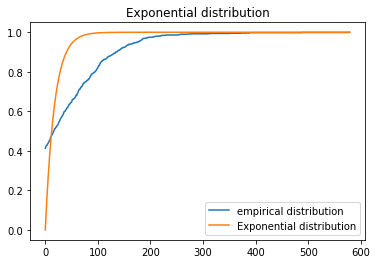

Kolmagorov statistic: 13.060206736495408
p_value: 7.239266547492108e-155


In [12]:
np.random.shuffle(dataset_2)
process_dataset(dataset_2[:1000]) #heavy computations

mean: 0.121771713
variance: 0.02557514673404663



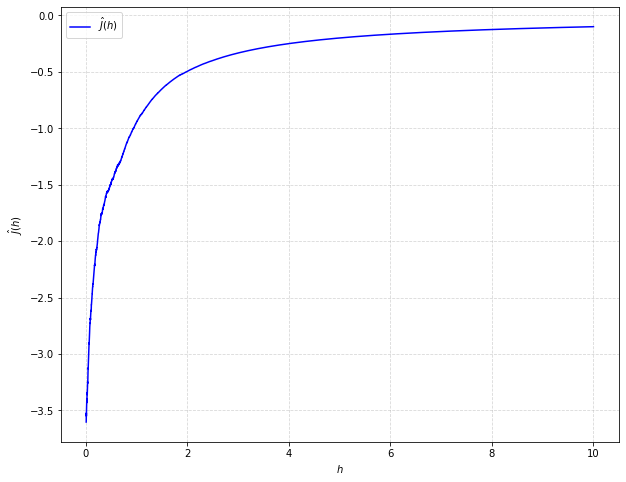

h = 0.01, J = -3.6035997997998


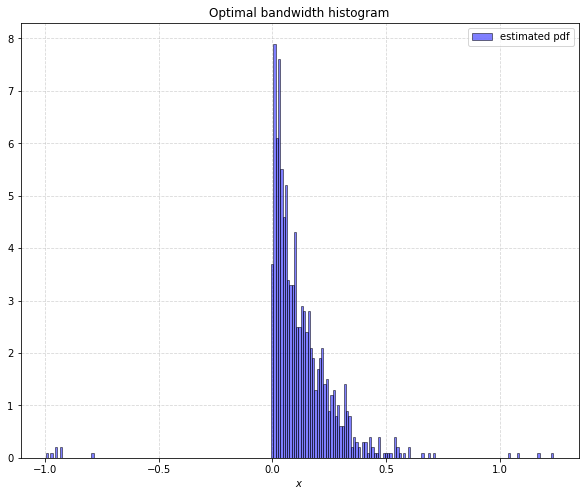

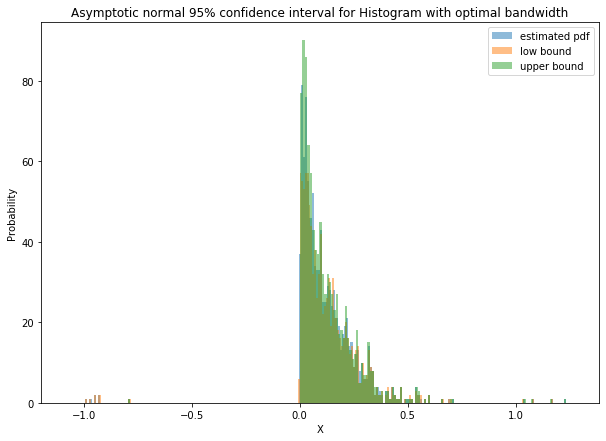

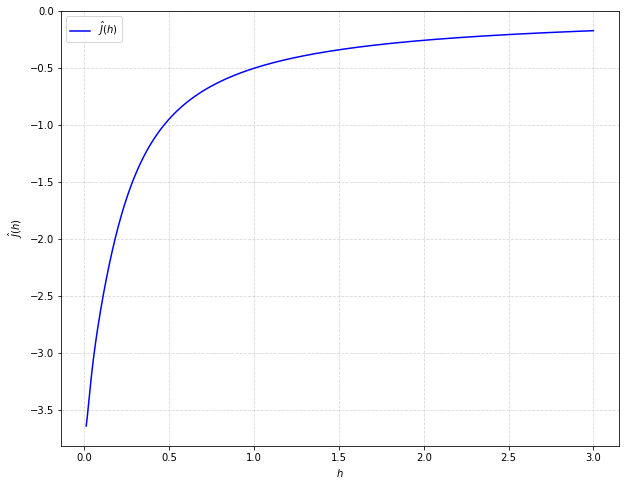

h = 0.01, J = -3.6408366180430587


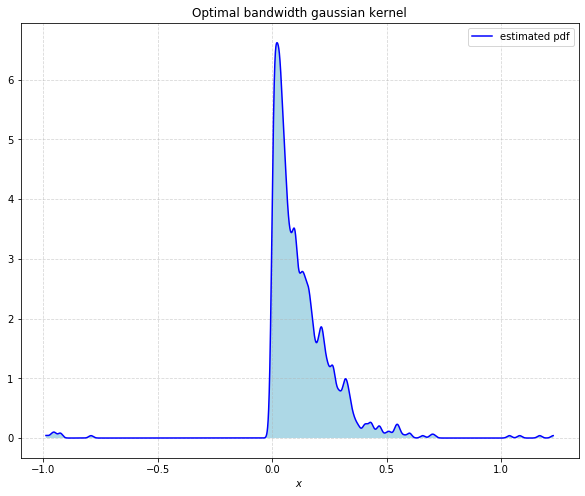

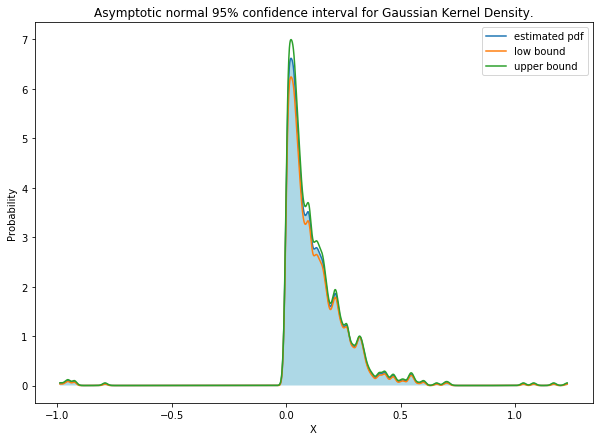

Uniform distribution
Estiamted a: -0.15522186129756355
Estimated b: 0.39876528729756355
95% Confidence interval for a: -0.19560572146961808, -0.11483800112550901
95% Confidence interval for b: 0.35959515529720487, 0.43793541929792223


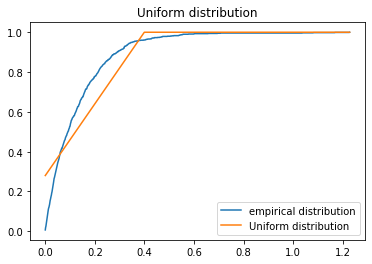

Kolmagorov statistic: 8.63903787798247
p_value: 1.94734715966566e-66

Norm distribution
Estimated mean: 0.121771713
Estimated var: 0.02557514673404663
95% Confidence interval for mean: 0.11201229159201088, 0.13153113440798914
95% Confidence interval for var: 0.01841779760395965, 0.03273249586413361


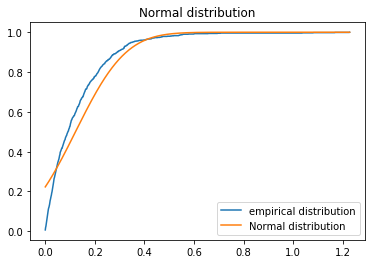

Kolmagorov statistic: 6.836726738908828
p_value: 1.6430781505237035e-41

Exponential
Estiamted lambda: 8.212087810573873
95% Confidence interval: 7.543644891335681, 8.880530729812065


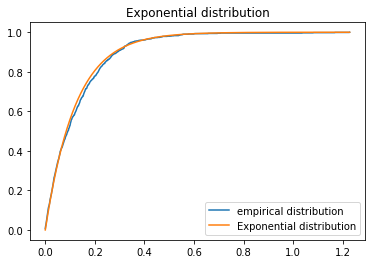

Kolmagorov statistic: 1.2342052769376806
p_value: 0.09256358739220971


In [13]:
np.random.shuffle(dataset_3)
process_dataset(dataset_3[:1000], descrete=False) #heavy computations

### Additional functions###

In [10]:
def geometric_distribution(x, p):
    return 1 - (1 - p) ** x


def binomial_distribution(x, n, p):
    result = 0
    if x < 0:
        return 0
    
    for k in range(0, int(x)):
        result += p ** k * (1 - p) ** (n - k) * math.comb(n, k)
        
    return result


def poisson_distribution(x, l):
    return l ** x * math.exp(-l) / math.factorial(abs(int(x)))


def uniform_distribution(x, a, b):
    if x < a:
        return 0
    
    if x > b:
        return 1
    
    
    return (x - a) / (b - a)


def normal_distribution(x, mu, se):
    return 0.5 * math.erf((x- mu) / se) + 0.5


def exponential_distribution(x, l):
    if x <= 0:
        return 0
    
    
    return 1 - np.exp(-1 * x * l)